# Import, Init

In [1]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8zyhd9wr because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

NULLS in data -->  0
>>> train-test inited:  
 	X_train len -->  1994 y_train len -->  1994 
 	X_test len -->  1992 y_test len -->  1992 
 	NULLS in data -->  0


In [4]:
# loaded

nn_manager_cut.y_train = nn_manager_cut.X_train.pop('Next_day_Price')
nn_manager_cut.y_test = nn_manager_cut.X_test.pop('Next_day_Price')

nn_manager_cut.X_train.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

In [5]:
# nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
#        'BTC_MINED_PDAY'], inplace=True, errors='ignore')
# nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open','TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
#        'BTC_MINED_PDAY'], inplace=True, errors='ignore')

## SR: MWNUS_CH_PDAY is not refreshed in the source DS => supplies nulls for last week
nn_manager_cut.X_test.drop(columns=[ 'MWNUS_CH_PDAY', 'Open'], inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=[ 'MWNUS_CH_PDAY', 'Open'], inplace=True, errors='ignore')

nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

In [6]:
nn_manager_cut.count_nulls_in_data()

NULLS in data -->  0


In [78]:
nn_manager_cut.y_test

Date
2016-01-02      430.7
2016-01-03      433.3
2016-01-04      431.2
2016-01-05      430.8
2016-01-06      457.0
               ...   
2021-06-11    35467.5
2021-06-12    39022.9
2021-06-13    40529.4
2021-06-14    40156.1
2021-06-15    38336.0
Name: Next_day_Price, Length: 1992, dtype: float64

## Trial

#### Adding Price as a column (we predict price for the next day, therefore price for current day is eligible)

In [7]:
# nn_manager_cut.X_train = nn_manager_cut.X_train.merge(nn_manager_cut.y_train, right_index=True, left_index=True, how='left')
# nn_manager_cut.X_test = nn_manager_cut.X_test.merge(nn_manager_cut.y_test, right_index=True, left_index=True, how='left')

# nn_manager_cut.X_train[:2]

# Preparing data

#### Swapping (the trial issue)
[[to #Model-fit]](#Model-fit)

In [8]:
tmp = nn_manager_cut.X_test.copy()
nn_manager_cut.X_test = nn_manager_cut.X_train.copy()
nn_manager_cut.X_train = tmp.copy()

tmp = nn_manager_cut.y_test.copy()
nn_manager_cut.y_test = nn_manager_cut.y_train.copy()
nn_manager_cut.y_train = tmp.copy()

print("X_train => ", nn_manager_cut.X_train.shape[0])
print("X_test => ", nn_manager_cut.X_test.shape[0])
print("\ttrain data period => ", nn_manager_cut.X_train.index.min(), "-->", nn_manager_cut.X_train.index.max())
print("\ttest data period => ", nn_manager_cut.X_test.index.min(), "-->", nn_manager_cut.X_test.index.max())

X_train =>  1992
X_test =>  1994
	train data period =>  2016-01-02 00:00:00 --> 2021-06-15 00:00:00
	test data period =>  2010-07-18 00:00:00 --> 2016-01-01 00:00:00


#### Keeping some Samples Aside

In [9]:
left_off_days = 21
left_off_X = nn_manager_cut.X_train[-left_off_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-left_off_days]

left_off_y = nn_manager_cut.y_train[-left_off_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-left_off_days]

print("X_train, X_test => ", nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0])
print("\ttrain data period => ", nn_manager_cut.X_train.index.min(), "-->", nn_manager_cut.X_train.index.max())
print("\ttest data period => ", nn_manager_cut.X_test.index.min(), "-->", nn_manager_cut.X_test.index.max())

X_train, X_test =>  1971 1994
	train data period =>  2016-01-02 00:00:00 --> 2021-05-25 00:00:00
	test data period =>  2010-07-18 00:00:00 --> 2016-01-01 00:00:00


## Normalizing

In [10]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

(
    nn_manager_cut.X_test_normalized[:2], 
#     nn_manager_cut.X_test_transformed
)

(array([[-0.82604885, -0.82352348, -0.33692929, -1.2892465 , -0.6648523 ,
         -2.99792455, -1.24649385, 13.09502262,  0.03948667, -2.22389752],
        [-0.82604885, -0.82352348, -0.33590187, -1.29460087, -0.66814668,
         -2.99746938, -1.24649156, 13.09502262,  0.03948667, -2.22389752]]),)

### Setting sequence len

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

In [11]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=1))

self.training_seq_params -->  {'seq_len': 1, 'n_features': 10}
self.X_train_shape -->  [1, 10]
self.X_test_shape -->  [1, 10]


True

# Model

In [12]:
nn_manager_cut.unroll_train_test_to_sequences()

True

In [13]:
nn_manager_cut.X_train_unrolled[0]

array([[-0.77476152, -0.77833493, -0.2433157 , -1.        , -0.7804252 ]])

In [14]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_train_unrolled[1]

array([[-0.77514743, -0.77882939, -0.24668019, -1.        , -0.7804748 ]])

In [15]:
# watching if shift is present
nn_manager_cut.y_train.iloc[:6], nn_manager_cut.y_train_unrolled[:6]

(            Price
 Date             
 2016-01-05  431.2
 2016-01-06  430.8
 2016-01-07  457.0
 2016-01-08  452.9
 2016-01-09  448.3
 2016-01-10  446.2,
 array([[430.8],
        [457. ],
        [452.9],
        [448.3],
        [446.2],
        [447.7]]))

In [16]:
X, _ = nn_manager_cut._unroll_XY_to_sequence(X=nn_manager_cut.X_train, y=nn_manager_cut.y_train, asarray=False, dataframe=True)
pd.concat(X)[:2]

,High,Low,Vol,PRICE_UP,Price
Date,,,,,
2016-01-05,435.3,428.9,45030.0,0,431.2
2016-01-06,432.1,425.0,43430.0,0,430.8


## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

In [92]:
x_train_try, _ = nn_manager_cut._unroll_XY_to_sequence(X=nn_manager_cut.X_train, y=nn_manager_cut.y_train, asarray=False, dataframe=True)
x_train_try = pd.concat(x_train_try)
x_train_try

KeyError: 'seq_len'

### Architectures

In [11]:
x_train_try, _ = nn_manager_cut._unroll_XY_to_sequence(X=nn_manager_cut.X_train, y=nn_manager_cut.y_train, asarray=False, dataframe=True)
# x_train_try = pd.concat(x_train_try)
x_train_try[:3]

[             High    Low      Vol         TOUTV      TRFEE     AVBLS  \
 Date                                                                   
 2014-12-02  384.9  375.4  25290.0  1.219368e+06  14.196577  0.391369   
 
                  NTRAT  BTC_MINED_PDAY  VOL_CHANGE_PDAY  NTRAT_CH_PDAY  
 Date                                                                    
 2014-12-02  52875294.0           350.0           5620.0       -72200.0  ,
              High    Low      Vol         TOUTV      TRFEE     AVBLS  \
 Date                                                                   
 2014-12-03  384.7  373.6  23510.0  1.221570e+06  14.051231  0.355757   
 
                  NTRAT  BTC_MINED_PDAY  VOL_CHANGE_PDAY  NTRAT_CH_PDAY  
 Date                                                                    
 2014-12-03  53145619.0          6375.0          -1780.0       270325.0  ,
              High    Low      Vol         TOUTV      TRFEE     AVBLS  \
 Date                                  

#### Keras imports

In [12]:
from tensorflow.keras.layers import (
    Input,
    Flatten,
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### Dense Architecture-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [13]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(1, 10)

In [14]:
# Dense Architecture

weights_init = GlorotNormal()

template_DNS = [
    Input(shape=input_model_shape),
    Flatten(),
    Dense(150,           
          kernel_initializer=weights_init
         ),
    Dense(450, 
          kernel_initializer=weights_init
         ),
    Dense(250, 
          kernel_initializer=weights_init
         ),
    Dense(50, 
          kernel_initializer=weights_init
         ),
    Dense(1, kernel_initializer=weights_init)
]

In [87]:
nn_manager_cut.X_train_unrolled.shape

AttributeError: 'NoneType' object has no attribute 'shape'

### Compiling Model with the chosen Architecture

In [92]:
x_train_try, _ = nn_manager_cut._unroll_XY_to_sequence(X=nn_manager_cut.X_train, y=nn_manager_cut.y_train, asarray=False, dataframe=True)
x_train_try = pd.concat(x_train_try)
x_train_try

KeyError: 'seq_len'

In [92]:
x_train_try, _ = nn_manager_cut._unroll_XY_to_sequence(X=nn_manager_cut.X_train, y=nn_manager_cut.y_train, asarray=False, dataframe=True)
x_train_try = pd.concat(x_train_try)
x_train_try

KeyError: 'seq_len'

In [15]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=1e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_DNS, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 28,401
Trainable params: 28,401
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [16]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1, 10], [1, 10])

In [12]:
unrolled_X, unrolled_y = nn_manager_cut._unroll_XY_to_sequence(nn_manager_cut.X_train, nn_manager_cut.y_train, dataframe=True, asarray=False)

unrolled_X[:2]

[             High    Low      Vol         TOUTV      TRFEE     AVBLS  \
 Date                                                                   
 2014-12-02  384.9  375.4  25290.0  1.219368e+06  14.196577  0.391369   
 2014-12-03  384.7  373.6  23510.0  1.221570e+06  14.051231  0.355757   
 2014-12-04  380.4  366.2  25330.0  1.282270e+06  13.716983  0.331026   
 2014-12-05  379.7  366.4  29990.0  6.805097e+05  12.382349  0.324024   
 
                  NTRAT  BTC_MINED_PDAY  VOL_CHANGE_PDAY  NTRAT_CH_PDAY  
 Date                                                                    
 2014-12-02  52875294.0           350.0           5620.0       -72200.0  
 2014-12-03  53145619.0          6375.0          -1780.0       270325.0  
 2014-12-04  53238519.0          3750.0           1820.0        92900.0  
 2014-12-05  53171881.0          3625.0           4660.0       -66638.0  ,
              High    Low      Vol         TOUTV      TRFEE     AVBLS  \
 Date                                     

In [13]:
unrolled_y[:2]

[Price    376.3
 Name: 2014-12-06 00:00:00, dtype: float64,
 Price    376.5
 Name: 2014-12-07 00:00:00, dtype: float64]

In [17]:
%%time
res = nn_manager_cut.model.fit(
    nn_manager_cut.X_train, nn_manager_cut.y_train,
    epochs=700,
    batch_size=32,
     validation_data = (nn_manager_cut.X_test, nn_manager_cut.y_test),
    verbose=0
)

CPU times: user 1min 29s, sys: 17.9 s, total: 1min 47s
Wall time: 46.6 s


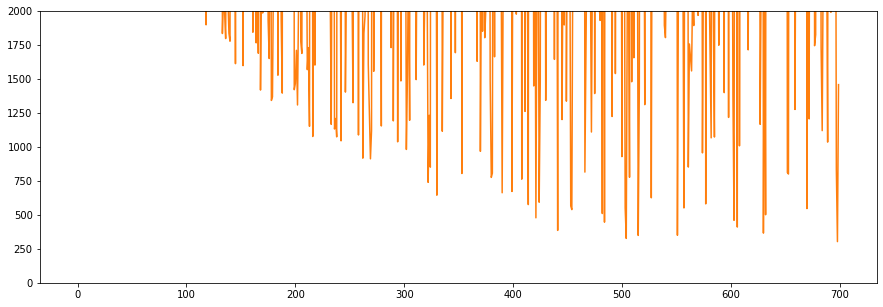

In [21]:
fig, ax = plt.subplots(1, figsize=(15,5))

plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

Train-Test split after swapping data [[go]](#Swapping-(the-trial-issue))

# Saving Model

In [19]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_58_171_Bidi_Stacked_3d')

In [20]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

In [21]:
# predicting for piece of train data '2014-12-02'

X = nn_manager_cut.scaler.transform(nn_manager_cut.X_train.loc['2016-01-06'].values.reshape(1, -1))

nn_manager_cut.model_predict(X.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0]

array([-0.08765146], dtype=float32)

In [22]:
nn_manager_cut.y_train.loc['2016-01-06':'2016-01-08']

Date
2016-01-06    457.0
2016-01-07    452.9
2016-01-08    448.3
Name: Next_day_Price, dtype: float64

### Plotting 

In [23]:
left_off_X[:2]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY
Date,,,,,,,,,,
2021-05-26,40750.0,37847.0,153800.0,2.222384e+06,77.846658,1.300155,644838441.0,756.25,-9210.0,233414.0
2021-05-27,40322.2,37190.8,122930.0,1.982669e+06,66.114770,1.262394,645069798.0,718.75,-30870.0,231357.0


In [24]:
left_off_X.shape

(21, 10)

In [25]:
left_off_X_unrolled, _ = nn_manager_cut.unroll_train_test_to_sequences(
    X=nn_manager_cut.scaler.transform(left_off_X), 
    y =left_off_y.values
)

left_off_X_unrolled.shape, left_off_X_unrolled[:2]

>>> Method called with outer X and y. Returning X, y unrolled...


((20, 1, 10),
 array([[[ 4.10010699,  3.9440193 , -0.01461446,  0.50154671,
           0.15913311,  0.96332407,  1.10807338, -0.72850679,
          -0.0881869 , -0.49828393]],
 
        [[ 4.04839129,  3.86135833, -0.07934162,  0.3044222 ,
           0.03445783,  0.84819505,  1.10891827, -0.75565611,
          -0.37328068, -0.51353215]]]))

In [26]:
left_off_X[:2]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY
Date,,,,,,,,,,
2021-05-26,40750.0,37847.0,153800.0,2.222384e+06,77.846658,1.300155,644838441.0,756.25,-9210.0,233414.0
2021-05-27,40322.2,37190.8,122930.0,1.982669e+06,66.114770,1.262394,645069798.0,718.75,-30870.0,231357.0


In [27]:
left_off_date_index_predicted_price = left_off_y.index[nn_manager_cut.training_seq_params['seq_len']:]

In [68]:
nn_manager_cut.y_train.loc['2014-12-02':'2014-12-10']

,Price
Date,
2014-12-02,380.6
2014-12-03,377.0
2014-12-04,369.8
2014-12-05,377.6
2014-12-06,376.3
2014-12-07,376.5
2014-12-08,365.0
2014-12-09,352.2
2014-12-10,347.9


In [28]:
left_off_pred = [nn_manager_cut.model_predict(seq.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0]
                 for seq in left_off_X_unrolled]

left_off_pred = pd.DataFrame(data=left_off_pred, index=left_off_date_index_predicted_price, columns=["left_off_pred"])
left_off_pred[:2]

,left_off_pred
Date,
2021-05-27,0.005615
2021-05-28,0.012151


In [29]:
X = nn_manager_cut.scaler.transform(left_off_X.loc['2021-06-02'].values.reshape(1, -1))

nn_manager_cut.model_predict(X.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0]

array([0.003781], dtype=float32)

In [30]:
left_off_X_unrolled[0].shape

(1, 10)

<AxesSubplot:xlabel='Date'>

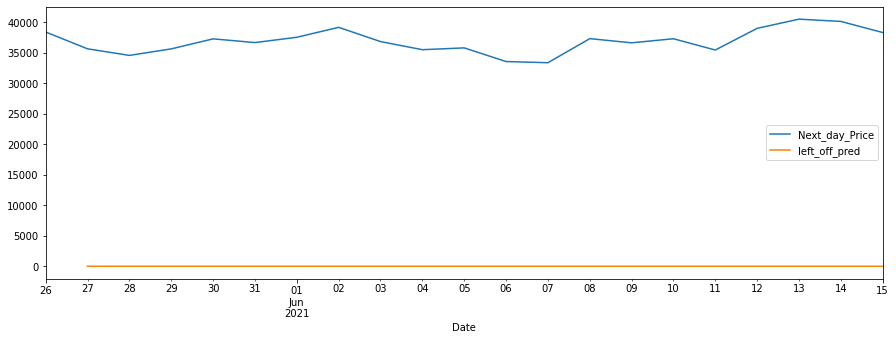

In [31]:
fig, ax = plt.subplots(1, figsize=(15,5))

pd.DataFrame(data=left_off_y).plot(ax=ax)
pd.DataFrame(data=left_off_pred).plot(ax=ax)

In [32]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2014-11-10'", "Date<='2014-11-17'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [33]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [34]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [35]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [36]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [37]:
# nn_manager_cut.y_test_unrolled[:3]

In [38]:
# nn_manager_cut.y_pred[:3]

In [39]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]

# Conclusion on LSTM Model:

In [27]:
left_off_X_unrolled_try, left_off_y_unrolled_try = nn_manager_cut._unroll_XY_to_sequence(
    X=(left_off_X), 
    y =left_off_y,
    asarray=False,
    dataframe=True
)
left_off_X_unrolled_try[:2]

[               High      Low      Vol         TOUTV      TRFEE     AVBLS  \
 Date                                                                       
 2021-06-02  38199.9  35981.1  96890.0  1.153282e+06  51.133097  1.291096   
 
                   NTRAT  BTC_MINED_PDAY  VOL_CHANGE_PDAY  NTRAT_CH_PDAY  
 Date                                                                     
 2021-06-02  646341383.0          1212.5         -16590.0       233352.0  ,
                High      Low       Vol         TOUTV      TRFEE     AVBLS  \
 Date                                                                        
 2021-06-03  39462.3  37193.6  106440.0  1.223004e+06  49.880615  1.293654   
 
                   NTRAT  BTC_MINED_PDAY  VOL_CHANGE_PDAY  NTRAT_CH_PDAY  
 Date                                                                     
 2021-06-03  646592644.0           775.0           9550.0       251261.0  ]

In [36]:
left_off_y_unrolled

array([[35520. ],
       [35815.4],
       [33578. ],
       [33382.9],
       [37332.2],
       [36649.4],
       [37314.6],
       [35467.5],
       [39022.9],
       [40529.4],
       [40156.1],
       [38336. ],
       [38052. ],
       [35749.4],
       [35513.4],
       [35595.8],
       [31692. ],
       [32496.4]])

In [25]:
left_off_X.iloc[-1]

High               3.327250e+04
Low                2.890180e+04
Vol                3.096500e+05
TOUTV              1.936917e+06
TRFEE              4.779617e+01
AVBLS              1.392933e+00
NTRAT              6.507957e+08
BTC_MINED_PDAY     4.375000e+02
VOL_CHANGE_PDAY    5.278000e+04
NTRAT_CH_PDAY      2.075770e+05
PRICE_UP           1.000000e+00
Name: 2021-06-22 00:00:00, dtype: float64